In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import math
class Tanh(nn.Module):
    def forward(self, x):
        return 1.7159 * torch.tanh(x * 2 / 3)

class Lenet5(nn.Module):
    def __init__(self):
        super(Lenet5, self).__init__()
        self.tanh = Tanh()
        #c1 layer
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        Fi, _ = nn.init._calculate_fan_in_and_fan_out(self.c1.weight)
        nn.init.uniform_(self.c1.weight, a=-2.4 / Fi, b=2.4 / Fi)
        self.c1.bias.data.fill_(2.4/Fi)

        #s2 layer
        self.s2_weight = nn.Parameter(torch.Tensor(1,6,1,1))
        self.s2_bias = nn.Parameter(torch.Tensor(1,6,1,1))
        Fi, _ = nn.init._calculate_fan_in_and_fan_out(self.s2_weight)
        nn.init.uniform_(self.s2_weight, a=-2.4 / Fi, b=2.4 / Fi)
        self.s2_bias.data.fill_(2.4/Fi)

        #c3 layer
        self.c3_weight = nn.Parameter(torch.Tensor(10, 6, 5, 5))
        self.c3_bias = nn.Parameter(torch.Tensor(1, 16, 1, 1))
        Fi, _ = nn.init._calculate_fan_in_and_fan_out(self.c3_weight)
        nn.init.uniform_(self.c3_weight, a=-2.4 / Fi, b=2.4 / Fi)
        self.c3_bias.data.fill_(2.4/Fi)

        #s4 layer
        self.s4_weight = nn.Parameter(torch.Tensor(1,16,1,1))
        self.s4_bias = nn.Parameter(torch.Tensor(1,16,1,1))
        Fi, _ = nn.init._calculate_fan_in_and_fan_out(self.s4_weight)
        nn.init.uniform_(self.s4_weight, a=-2.4 / Fi, b=2.4 / Fi)
        self.s4_bias.data.fill_(2.4/Fi)

        #c5 layer
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        Fi, _ = nn.init._calculate_fan_in_and_fan_out(self.c5.weight)
        nn.init.uniform_(self.c5.weight, a=-2.4 / Fi, b=2.4 / Fi)
        self.c5.bias.data.fill_(2.4/Fi)
        #f6 layer
        self.f6 = nn.Linear(in_features=120, out_features=84)
        Fi, _ = nn.init._calculate_fan_in_and_fan_out(self.f6.weight)
        nn.init.uniform_(self.f6.weight, a=-2.4 / Fi, b=2.4 / Fi)
        self.f6.bias.data.fill_(2.4/Fi)
        self.rbf_params = self.rbf_tensor().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
      
    def move_to_cpu(self):
        self.to('cpu')  
        self.rbf_params = self.rbf_params.to('cpu')  
        print("Model moved to CPU")
    def custom_connection(self):
        return [
            [0, 4, 5, 6, 9, 10, 11, 12, 14, 15],
            [0, 1, 5, 6, 7, 10, 11, 12, 13, 15],
            [0, 1, 2, 6, 7, 8, 11, 13, 14, 15],
            [1, 2, 3, 6, 7, 8, 9, 12, 14, 15],
            [2, 3, 4, 7, 8, 9, 10, 12, 13, 15],
            [3, 4, 5, 8, 9, 10, 11, 13, 14, 15]
        ]
    def rbf(self, x):
        x_expanded = x.unsqueeze(1).expand((x.size(0), self.rbf_params.size(0), self.rbf_params.size(1)))  
        params_expanded = self.rbf_params.unsqueeze(0).expand((x.size(0), self.rbf_params.size(0), self.rbf_params.size(1)))         
        output = (x_expanded - params_expanded).pow(2).sum(-1)
        return output
    def rbf_tensor(self):
        kernel_list = []
        root_dir = r"C:\Users\patel\Downloads\digits"
        bitmap_size = (7, 12)
        for root, dirs, files in os.walk(root_dir):
            for dir_name in dirs:
                if dir_name.isdigit():
                    folder_path = os.path.join(root, dir_name)
                    digit_images = []
                    for file_name in os.listdir(folder_path):
                        file_path = os.path.join(folder_path, file_name)
                        image = cv2.imread(file_path, 0)
                        if image is not None:
                            image = cv2.resize(image, bitmap_size)
                            digit_images.append(image)
                    if digit_images:
                        mean_image = np.mean(digit_images, axis=0)
                        mean_image = cv2.threshold(mean_image, 127, 1, cv2.THRESH_BINARY)[1].astype(np.int16) * -1 + 1
                        kernel_list.append(mean_image.flatten())
        kernel_array = np.array(kernel_list)
        return torch.tensor(kernel_array, dtype=torch.float32)
    def forward(self, x):
        x = self.c1(x)
        x = self.tanh(x)
        x = F.avg_pool2d(x, 2)*self.s2_weight + self.s2_bias
        x = self.tanh(x)
        output = torch.zeros(x.size(0), 16, x.size(3) - 5 + 1, x.size(3) - 5 + 1).to(x.device)
        custom = self.custom_connection()
        for i in range(len(custom)):
            output[:,custom[i],:,:] += (F.conv2d(x[:,i,:,:].unsqueeze(1),self.c3_weight[:,i,:,:].unsqueeze(1)) + self.c3_bias[:,custom[i],:,:])
        x = output
        x = self.tanh(x)
        x = F.avg_pool2d(x, 2)*self.s4_weight + self.s4_bias
        x = self.tanh(x)
        x = self.c5(x)
        x = self.tanh(x)
        x = torch.flatten(x, start_dim=1)
        x = self.f6(x)
        x = self.tanh(x)
        x = self.rbf(x)
        return x

In [33]:
model = Lenet5()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [30]:
import pandas as pd
from PIL import Image
splits = {'train': 'mnist/train-00000-of-00001.parquet', 'test': 'mnist/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["test"])


In [31]:
import torch.optim as optim
from PIL import Image
import io
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.PILToTensor()
])
train_images = []
y_train = []
for row in df_train.itertuples():
    image = Image.open(io.BytesIO(row[1]['bytes']))
    image = transform(image)  
    train_images.append(image)
    label = row[2]
    y_train.append(label)
train_images = torch.stack(train_images)
train_images = F.pad(train_images, (2, 2, 2, 2, 0, 0), mode='constant', value=0).float()
y_train = torch.tensor(y_train, dtype=torch.long)
y_train = nn.functional.one_hot(y_train, num_classes=10).float()            
test_images = []
y_test = []
for row in df_test.itertuples():
    image = Image.open(io.BytesIO(row[1]['bytes']))
    image = transform(image)  
    test_images.append(image)
    label = row[2]
    y_test.append(label)
test_images = torch.stack(test_images)
test_images = F.pad(test_images, (2, 2, 2, 2, 0, 0), mode='constant', value=0).float()
y_test = torch.tensor(y_test, dtype=torch.long)
train_loader = DataLoader(TensorDataset(train_images, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(test_images, y_test), batch_size=64, shuffle=True)

In [34]:
def loss_fn(output, target):
        loss = output[target==1].pow(2).sum()
        loss += torch.log(np.exp(-0.1) + torch.exp(-output[target==0]).sum())
        loss /= output.size(0)
        return loss
def train(model, epoch):
    optimizer = optim.SGD(model.parameters(), lr=0.001)    
    train_accuracy_list = []
    test_accuracy_list = []
    for i in range(epoch):
        train_accuracy = 0.0        
        model.train()
        for data, target in train_loader:
            data = data.to(device)  
            target = target.to(device)  
            optimizer.zero_grad()  
            y_pred = model(data) 
            loss = loss_fn(y_pred, target)  
            loss.backward()  
            optimizer.step() 
            train_accuracy += (torch.argmin(y_pred, dim=1) == torch.argmax(target, dim=1)).sum().item()
        train_accuracy /= len(train_loader.dataset)
        train_accuracy_list.append(train_accuracy)
        model.eval()
        test_accuracy = 0.0
        with torch.no_grad():  
            for data, target in test_loader:
                data = data.to(device)
                target = target.to(device)
                y_pred = model(data)
                test_accuracy += (torch.argmin(y_pred,dim=1)==target).sum().item()
            test_accuracy /= len(test_loader.dataset)
            test_accuracy_list.append(test_accuracy)
        print(f'epoch : {i+1}/{epoch}, train_acc : {train_accuracy:.6f}, test_acc : {test_accuracy:.6f}')
    return train_accuracy_list, test_accuracy_list
train_acc, test_acc = train(model, 20)

epoch : 1/20, train_acc : 0.195683, test_acc : 0.634700
epoch : 2/20, train_acc : 0.843050, test_acc : 0.923300
epoch : 3/20, train_acc : 0.930550, test_acc : 0.933500
epoch : 4/20, train_acc : 0.946517, test_acc : 0.955500
epoch : 5/20, train_acc : 0.955183, test_acc : 0.960100
epoch : 6/20, train_acc : 0.960067, test_acc : 0.963500
epoch : 7/20, train_acc : 0.963483, test_acc : 0.968800
epoch : 8/20, train_acc : 0.966650, test_acc : 0.968800
epoch : 9/20, train_acc : 0.968267, test_acc : 0.957700
epoch : 10/20, train_acc : 0.969000, test_acc : 0.971000
epoch : 11/20, train_acc : 0.971033, test_acc : 0.972900
epoch : 12/20, train_acc : 0.972733, test_acc : 0.974800
epoch : 13/20, train_acc : 0.972350, test_acc : 0.975500
epoch : 14/20, train_acc : 0.974817, test_acc : 0.975600
epoch : 15/20, train_acc : 0.974933, test_acc : 0.976000
epoch : 16/20, train_acc : 0.976133, test_acc : 0.976500
epoch : 17/20, train_acc : 0.975983, test_acc : 0.977400
epoch : 18/20, train_acc : 0.976900, tes

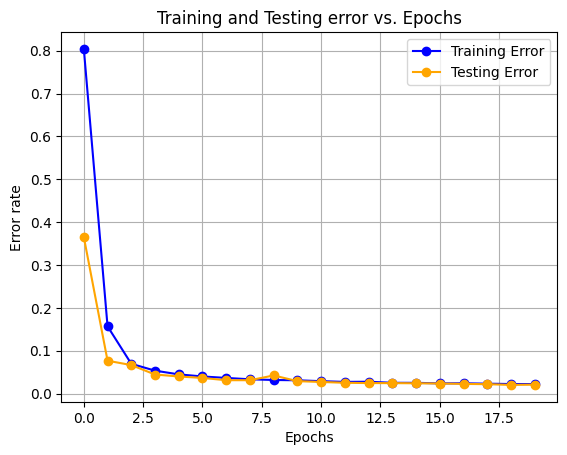

In [35]:
import matplotlib.pyplot as plt
plt.plot([1-acc for acc in train_acc], label='Training Error', marker='o', color = "blue")
plt.plot([1 - acc for acc in test_acc], label='Testing Error', marker='o', color = "orange")
plt.title("Training and Testing error vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Error rate")
plt.grid()
plt.legend()

In [36]:
from torchinfo import summary
summary(model, (1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Lenet5                                   [1, 10]                   1,560
├─Conv2d: 1-1                            [6, 28, 28]               156
├─Tanh: 1-2                              [6, 28, 28]               --
├─Tanh: 1-3                              [1, 6, 14, 14]            --
├─Tanh: 1-4                              [1, 16, 10, 10]           --
├─Tanh: 1-5                              [1, 16, 5, 5]             --
├─Conv2d: 1-6                            [1, 120, 1, 1]            48,120
├─Tanh: 1-7                              [1, 120, 1, 1]            --
├─Linear: 1-8                            [1, 84]                   10,164
├─Tanh: 1-9                              [1, 84]                   --
Total params: 60,000
Trainable params: 60,000
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.23
Estimated Total Size

(10000,) (10000,)


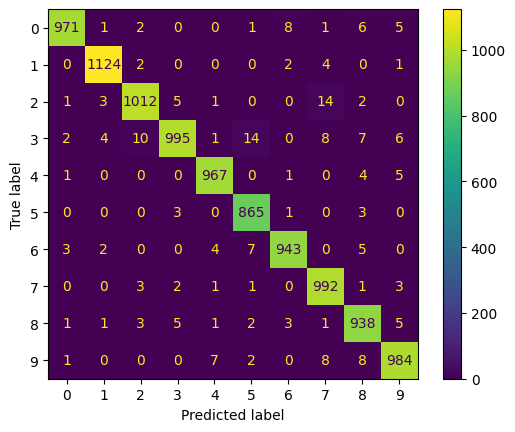

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_preds = []
y_labels = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)        
        y_pred = model(data)        
        _, predicted_labels = torch.min(y_pred, dim=1)
        y_preds.append(predicted_labels.cpu().numpy())  
        y_labels.append(target.cpu().numpy()) 
y_preds = np.concatenate(y_preds)
y_labels = np.concatenate(y_labels)
print(y_preds.shape, y_labels.shape)
cm = confusion_matrix(y_preds, y_labels)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()


Using device: cuda


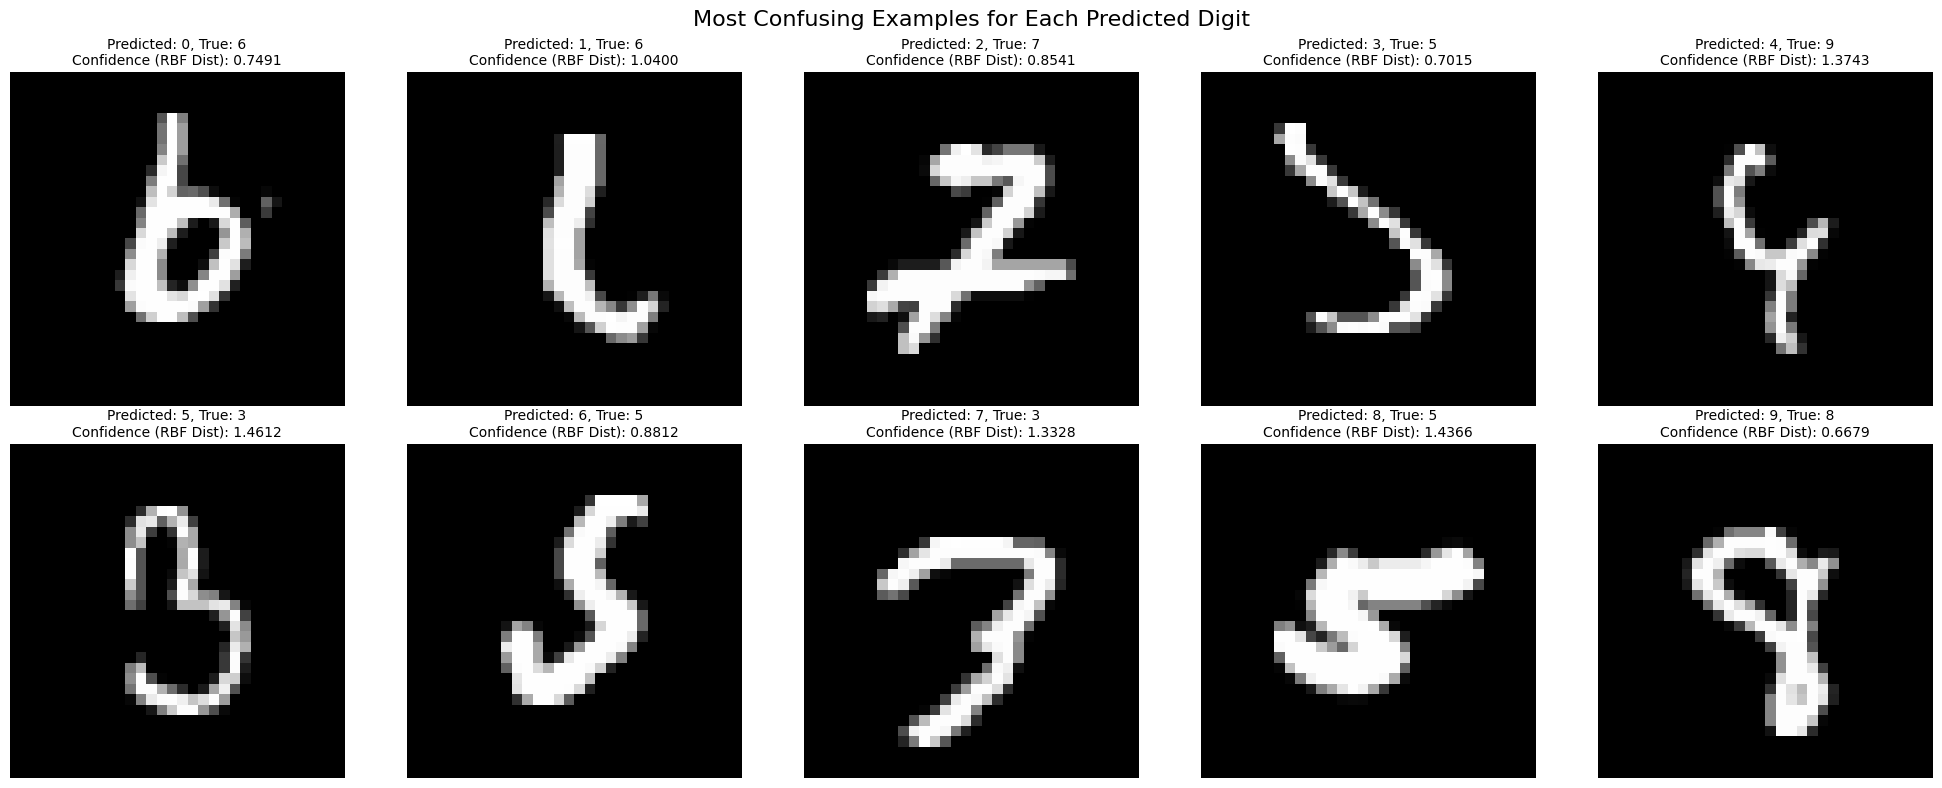

In [38]:
def find_most_confusing_examples(model, test_loader, device):
    model.eval()
    most_confusing = {digit: {'min_confidence': float('inf'),  
                               'image': None,
                               'true_label': None,
                               'rbf_values': None} for digit in range(10)}

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.argmin(outputs, dim=1)  
            
            for i in range(len(labels)):
                true_label = labels[i].item()
                predicted_label = predicted[i].item()
                rbf_values = outputs[i]
                confidence = rbf_values[predicted_label].item()                  
                if true_label != predicted_label:
                    if confidence < most_confusing[predicted_label]['min_confidence']:
                        most_confusing[predicted_label] = {
                            'min_confidence': confidence,
                            'image': images[i].cpu(),
                            'true_label': true_label,
                            'rbf_values': rbf_values.cpu()
                        }

    return most_confusing
def visualize_confusing_examples(most_confusing):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle('Most Confusing Examples for Each Predicted Digit', fontsize=16)
    for digit in range(10):
        row = digit // 5
        col = digit % 5
        conf_example = most_confusing[digit]
        if conf_example['image'] is not None:
            axs[row, col].imshow(conf_example['image'].squeeze(), cmap='gray')
            axs[row, col].set_title(
                f'Predicted: {digit}, True: {conf_example["true_label"]}\n' +
                f'Confidence (RBF Dist): {conf_example["min_confidence"]:.4f}',
                fontsize=10
            )
        else:
            axs[row, col].set_title(f'No Misclassifications\nPredicted: {digit}', fontsize=10)
        axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

most_confusing_examples = find_most_confusing_examples(model, test_loader, device)
visualize_confusing_examples(most_confusing_examples)


In [39]:
model.move_to_cpu()
torch.save(model, "C:\\Users\\Patel\\Downloads\\problem1.pth")


Model moved to CPU


PROBLEM 2

In [40]:
import torch
import torch.optim as optim
from PIL import Image
import io
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
from scipy.io import loadmat
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import random

#Transforms - decided to not include. Including the original dataset as well as data augmentation from affnist. Included code below for recod
'''
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),               
    transforms.RandomVerticalFlip(p=0.2),                 
    transforms.RandomRotation(degrees=30, expand=False),   
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=None, shear=None),  
    transforms.PILToTensor(),                           
])
'''

transform = transforms.Compose([
    transforms.PILToTensor()
])
#Affnist data inclusion
ran = random.randint(1, 32)
data = loadmat(f'C:\\Users\\patel\\Downloads\\training_and_validation_batches\\training_and_validation_batches\\{ran}.mat')
images = data['affNISTdata']['image'][0][0]
labels = data['affNISTdata']['label_int'][0][0]

affnist_train = []
affnist_train_label = []

for i in range(images.shape[1]):
    image_array = images[:, i].reshape(40, 40)    
    resized_image = Image.fromarray(np.uint8(image_array)).resize((28, 28), Image.LANCZOS)   
    resized_image = transform(resized_image) 
    affnist_train.append(resized_image)
    affnist_train_label.append(labels[0, i])


data = loadmat(f'C:\\Users\\patel\\Downloads\\test_batches\\test_batches\\{ran}.mat')
images = data['affNISTdata']['image'][0][0]
labels = data['affNISTdata']['label_int'][0][0]

affnist_test = []
affnist_test_label = []

for i in range(images.shape[1]):
    image_array = images[:, i].reshape(40, 40)    
    resized_image = Image.fromarray(np.uint8(image_array)).resize((28, 28), Image.LANCZOS)
    resized_image = transform(resized_image) 
    affnist_test.append(resized_image)
    affnist_test_label.append(labels[0, i])
#Model data creation
train_images = []
y_train = []
for row in df_train.itertuples():
    image = Image.open(io.BytesIO(row[1]['bytes']))
    image = transform(image)  
    train_images.append(image)
    label = row[2]
    y_train.append(label)
train_images.extend(affnist_train)
train_images = torch.stack(train_images)
train_images = F.pad(train_images, (2, 2, 2, 2, 0, 0), mode='constant', value=0).float()
y_train.extend(affnist_train_label)
y_train = torch.tensor(y_train, dtype=torch.long)
y_train = nn.functional.one_hot(y_train, num_classes=10).float()            
test_images = []
y_test = []
for row in df_test.itertuples():
    image = Image.open(io.BytesIO(row[1]['bytes']))
    image = transform(image)  
    test_images.append(image)
    label = row[2]
    y_test.append(label)
test_images.extend(affnist_test)
test_images = torch.stack(test_images)
test_images = F.pad(test_images, (2, 2, 2, 2, 0, 0), mode='constant', value=0).float()
y_test.extend(affnist_test_label)
y_test = torch.tensor(y_test, dtype=torch.long)

print(train_images.shape)
print(test_images.shape)
train_loader = DataLoader(TensorDataset(train_images, y_train), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(test_images, y_test), batch_size=128, shuffle=True)


torch.Size([120000, 1, 32, 32])
torch.Size([20000, 1, 32, 32])


In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import math
class Prob2(nn.Module):
    def __init__(self):
        super(Prob2, self).__init__()
        self.relu = nn.ReLU()
        #c1 layer
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        Fi, _ = nn.init._calculate_fan_in_and_fan_out(self.c1.weight)
        nn.init.uniform_(self.c1.weight, a=-2.4 / Fi, b=2.4 / Fi)
        self.c1.bias.data.fill_(2.4/Fi)

        #s2 layer
        self.s2_weight = nn.Parameter(torch.Tensor(1,6,1,1))
        self.s2_bias = nn.Parameter(torch.Tensor(1,6,1,1))
        Fi, _ = nn.init._calculate_fan_in_and_fan_out(self.s2_weight)
        nn.init.uniform_(self.s2_weight, a=-2.4 / Fi, b=2.4 / Fi)
        self.s2_bias.data.fill_(2.4/Fi)

        #c3 layer
        self.c3_weight = nn.Parameter(torch.Tensor(10, 6, 5, 5))
        self.c3_bias = nn.Parameter(torch.Tensor(1, 16, 1, 1))
        Fi, _ = nn.init._calculate_fan_in_and_fan_out(self.c3_weight)
        nn.init.uniform_(self.c3_weight, a=-2.4 / Fi, b=2.4 / Fi)
        self.c3_bias.data.fill_(2.4/Fi)

        #s4 layer
        self.s4_weight = nn.Parameter(torch.Tensor(1,16,1,1))
        self.s4_bias = nn.Parameter(torch.Tensor(1,16,1,1))
        Fi, _ = nn.init._calculate_fan_in_and_fan_out(self.s4_weight)
        nn.init.uniform_(self.s4_weight, a=-2.4 / Fi, b=2.4 / Fi)
        self.s4_bias.data.fill_(2.4/Fi)

        #c5 layer
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        Fi, _ = nn.init._calculate_fan_in_and_fan_out(self.c5.weight)
        nn.init.uniform_(self.c5.weight, a=-2.4 / Fi, b=2.4 / Fi)
        self.c5.bias.data.fill_(2.4/Fi)
        #f6 layer
        self.f6 = nn.Linear(in_features=120, out_features=84)
        Fi, _ = nn.init._calculate_fan_in_and_fan_out(self.f6.weight)
        nn.init.uniform_(self.f6.weight, a=-2.4 / Fi, b=2.4 / Fi)
        self.f6.bias.data.fill_(2.4/Fi)
        self.rbf_params = self.rbf_tensor().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        #Various prob2 layers
        self.batch1 = nn.BatchNorm2d(6)
        self.batch2 = nn.BatchNorm2d(16)
        self.batch3 = nn.BatchNorm2d(120)
        self.dropout1 = nn.Dropout(0.2)

    def custom_connection(self):
        return [
            [0, 4, 5, 6, 9, 10, 11, 12, 14, 15],
            [0, 1, 5, 6, 7, 10, 11, 12, 13, 15],
            [0, 1, 2, 6, 7, 8, 11, 13, 14, 15],
            [1, 2, 3, 6, 7, 8, 9, 12, 14, 15],
            [2, 3, 4, 7, 8, 9, 10, 12, 13, 15],
            [3, 4, 5, 8, 9, 10, 11, 13, 14, 15]
        ]
    def rbf(self, x):
        x_expanded = x.unsqueeze(1).expand((x.size(0), self.rbf_params.size(0), self.rbf_params.size(1)))  
        params_expanded = self.rbf_params.unsqueeze(0).expand((x.size(0), self.rbf_params.size(0), self.rbf_params.size(1)))         
        output = (x_expanded - params_expanded).pow(2).sum(-1)
        return output
    def rbf_tensor(self):
        kernel_list = []
        root_dir = r"C:\Users\patel\Downloads\digits"
        bitmap_size = (7, 12)
        for root, dirs, files in os.walk(root_dir):
            for dir_name in dirs:
                if dir_name.isdigit():
                    folder_path = os.path.join(root, dir_name)
                    digit_images = []
                    for file_name in os.listdir(folder_path):
                        file_path = os.path.join(folder_path, file_name)
                        image = cv2.imread(file_path, 0)
                        if image is not None:
                            image = cv2.resize(image, bitmap_size)
                            digit_images.append(image)
                    if digit_images:
                        mean_image = np.mean(digit_images, axis=0)
                        mean_image = cv2.threshold(mean_image, 127, 1, cv2.THRESH_BINARY)[1].astype(np.int16) * -1 + 1
                        kernel_list.append(mean_image.flatten())
        kernel_array = np.array(kernel_list)
        return torch.tensor(kernel_array, dtype=torch.float32)
    def move_to_cpu(self):
        self.to('cpu')  
        self.rbf_params = self.rbf_params.to('cpu')  
        print("Model moved to CPU")
    def forward(self, x):
        x = self.c1(x)
        x = self.batch1(x)
        x = self.relu(x)
        x = F.max_pool2d(x, 2)*self.s2_weight + self.s2_bias
        x = self.relu(x)
        output = torch.zeros(x.size(0), 16, x.size(3) - 5 + 1, x.size(3) - 5 + 1).to(x.device)
        custom = self.custom_connection()
        for i in range(len(custom)):
            output[:,custom[i],:,:] += (F.conv2d(x[:,i,:,:].unsqueeze(1),self.c3_weight[:,i,:,:].unsqueeze(1)) + self.c3_bias[:,custom[i],:,:])
        x = output
        x = self.batch2(x)
        x = self.relu(x)
        x = F.max_pool2d(x, 2)*self.s4_weight + self.s4_bias
        x = self.relu(x)
        x = self.c5(x)
        x = self.batch3(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, start_dim=1)
        x = self.f6(x)
        x = self.relu(x)
        x = self.rbf(x)
        return x
    

In [42]:
prob2 = Prob2()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prob2 = prob2.to(device)

In [43]:
def loss_fn(output, target):
        loss = output[target==1].pow(2).sum()
        loss += torch.log(np.exp(-0.1) + torch.exp(-output[target==0]).sum())
        loss /= output.size(0)
        return loss
def train(model, epoch):
    optimizer = optim.SGD(model.parameters(), lr=0.001)    
    train_accuracy_list = []
    test_accuracy_list = []
    for i in range(epoch):
        train_accuracy = 0.0        
        model.train()
        for data, target in train_loader:
            data = data.to(device)  
            target = target.to(device)  
            optimizer.zero_grad()  
            y_pred = model(data) 
            loss = loss_fn(y_pred, target)  
            loss.backward()  
            optimizer.step() 
            train_accuracy += (torch.argmin(y_pred, dim=1) == torch.argmax(target, dim=1)).sum().item()
        train_accuracy /= len(train_loader.dataset)
        train_accuracy_list.append(train_accuracy)
        model.eval()
        test_accuracy = 0.0
        with torch.no_grad():  
            for data, target in test_loader:
                data = data.to(device)
                target = target.to(device)
                y_pred = model(data)
                test_accuracy += (torch.argmin(y_pred,dim=1)==target).sum().item()
            test_accuracy /= len(test_loader.dataset)
            test_accuracy_list.append(test_accuracy)
        print(f'epoch : {i+1}/{epoch}, train_acc : {train_accuracy:.6f}, test_acc : {test_accuracy:.6f}')
    return train_accuracy_list, test_accuracy_list
train_acc, test_acc = train(prob2, 20)

epoch : 1/20, train_acc : 0.800367, test_acc : 0.785350
epoch : 2/20, train_acc : 0.905458, test_acc : 0.782100
epoch : 3/20, train_acc : 0.922967, test_acc : 0.840350
epoch : 4/20, train_acc : 0.932167, test_acc : 0.824100
epoch : 5/20, train_acc : 0.937475, test_acc : 0.931650
epoch : 6/20, train_acc : 0.941617, test_acc : 0.913500
epoch : 7/20, train_acc : 0.945858, test_acc : 0.602150
epoch : 8/20, train_acc : 0.947883, test_acc : 0.905200
epoch : 9/20, train_acc : 0.949725, test_acc : 0.935750
epoch : 10/20, train_acc : 0.951600, test_acc : 0.890050
epoch : 11/20, train_acc : 0.952517, test_acc : 0.890400
epoch : 12/20, train_acc : 0.953900, test_acc : 0.945000
epoch : 13/20, train_acc : 0.955717, test_acc : 0.927350
epoch : 14/20, train_acc : 0.955733, test_acc : 0.958100
epoch : 15/20, train_acc : 0.955892, test_acc : 0.956700
epoch : 16/20, train_acc : 0.958100, test_acc : 0.964100
epoch : 17/20, train_acc : 0.958425, test_acc : 0.936200
epoch : 18/20, train_acc : 0.959208, tes

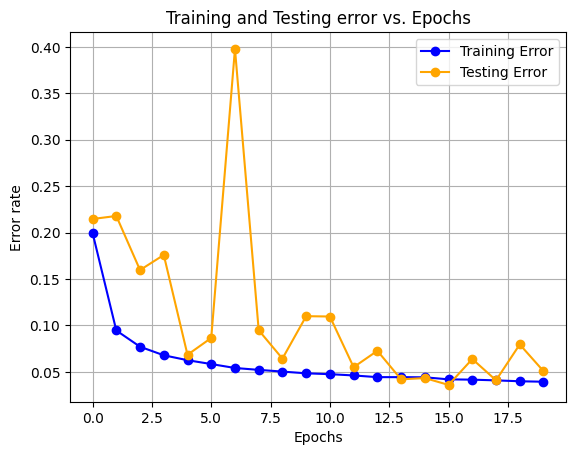

In [45]:
import matplotlib.pyplot as plt
plt.plot([1-acc for acc in train_acc], label='Training Error', marker='o', color = "blue")
plt.plot([1 - acc for acc in test_acc], label='Testing Error', marker='o', color = "orange")
plt.title("Training and Testing error vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Error rate")
plt.grid()
plt.legend()

In [44]:

prob2.move_to_cpu()
torch.save(prob2, "C:\\Users\\Patel\\Downloads\\problem2.pth")


Model moved to CPU
